# Notebook for Applications Paper

### Preprocessing

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.0.1+cu117
CUDA available: False
CUDA version: 11.7
CUDNN version: 8500


Preprocessing RNAseq, as per SCENIC+:

In [2]:
import os
work_dir = 'data/pbmc/'
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))

In [3]:
import scanpy as sc

# will edit this, to fit in with other diags
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

In [4]:
adata = sc.read_10x_h5(os.path.join(work_dir, 'pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5'))
adata.var_names_make_unique()
adata

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
sc.external.pp.scrublet(adata)

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 53.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.0%


In [7]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 2627 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'scrublet'

/tmp/ipykernel_80672/3790233708.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


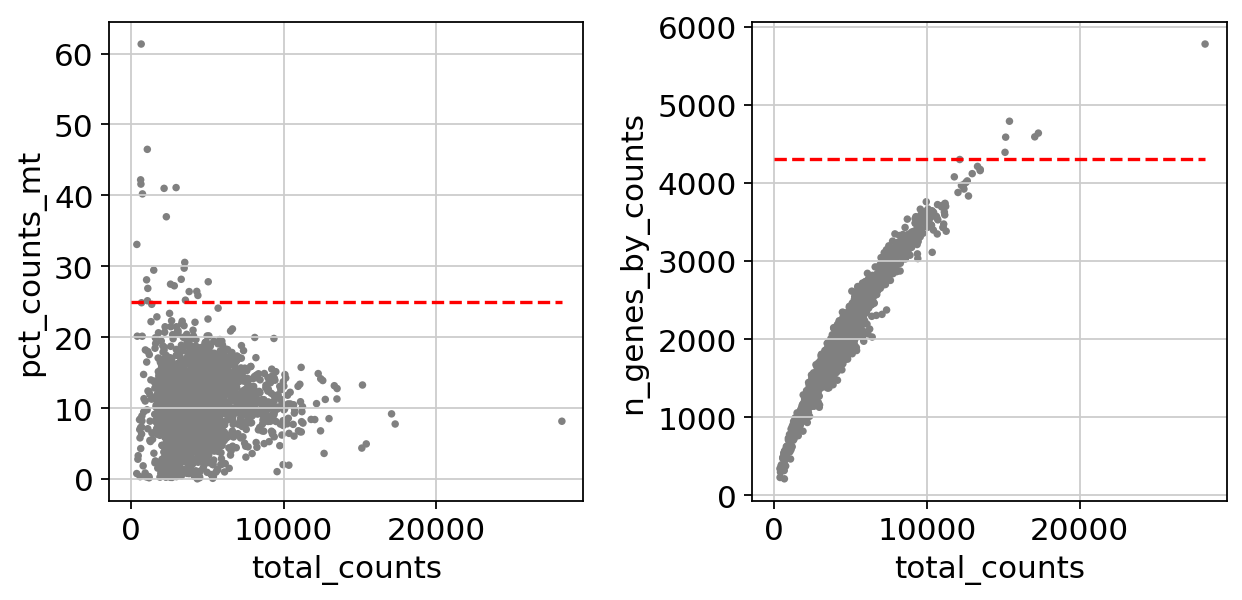

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [9]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 2598 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [10]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
adata_ref = sc.datasets.pbmc3k_processed() #use the preprocessed data from the Scanpy tutorial as reference
var_names = adata_ref.var_names.intersection(adata.var_names) #use genes which are present in both assays
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]
sc.pp.pca(adata_ref) #calculate PCA embedding
sc.pp.neighbors(adata_ref) #calculate neighborhood graph
sc.tl.umap(adata_ref) #calculate umap embedding
sc.tl.ingest(adata, adata_ref, obs='louvain') #run label transfer
adata.obs.rename({'louvain': 'ingest_celltype_label'}, inplace = True, axis = 1)

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


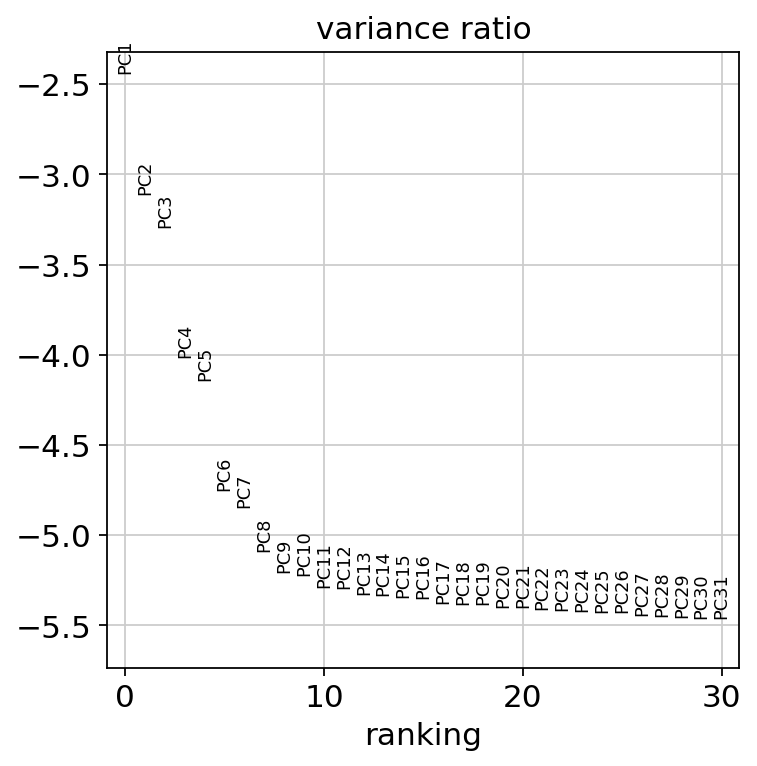

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


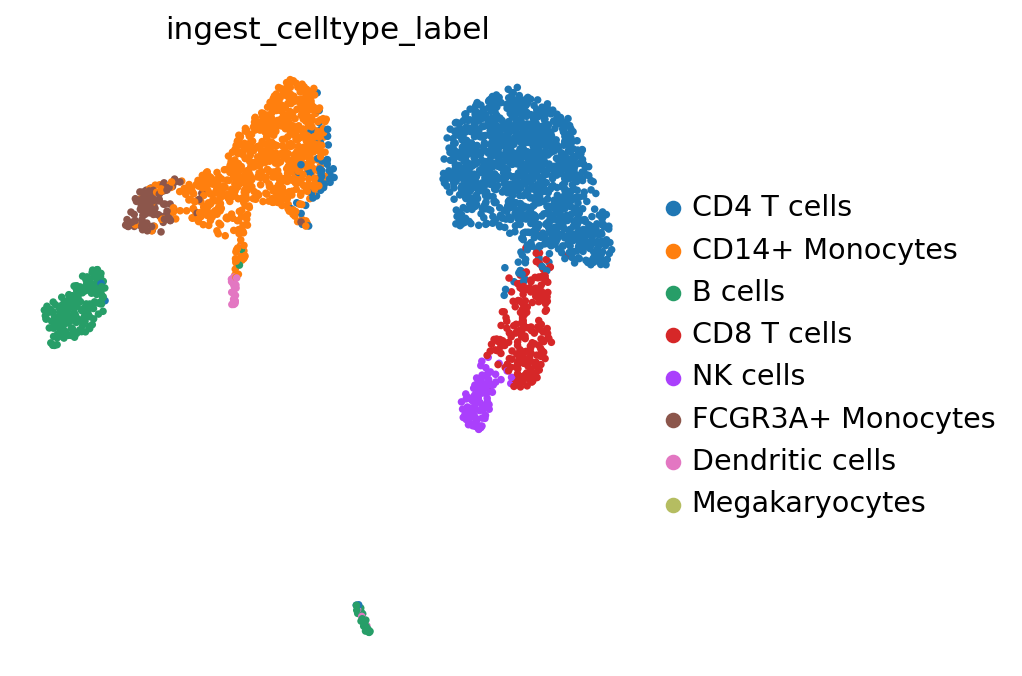

In [13]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'ingest_celltype_label')

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


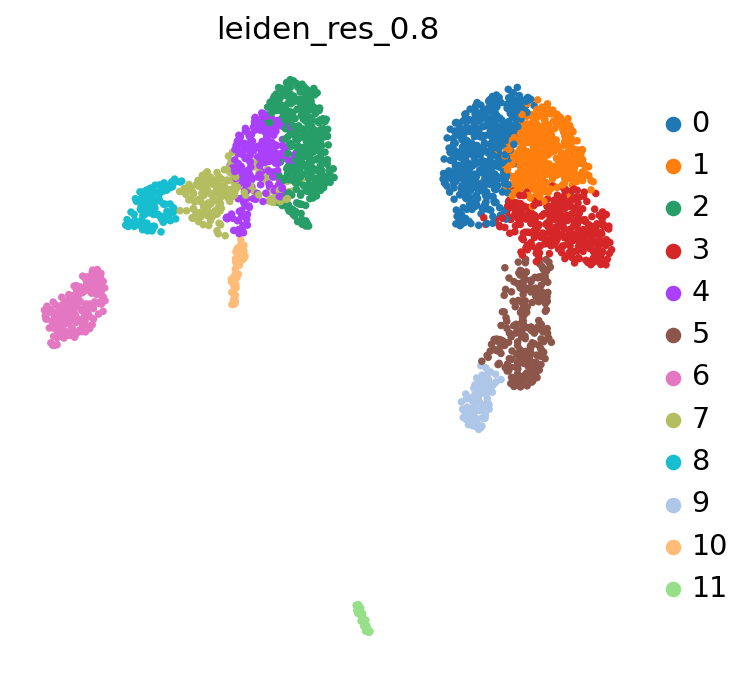

In [14]:
sc.tl.leiden(adata, resolution = 0.8, key_added = 'leiden_res_0.8')
sc.pl.umap(adata, color = 'leiden_res_0.8')

In [15]:
tmp_df = adata.obs.groupby(['leiden_res_0.8', 'ingest_celltype_label']).size().unstack(fill_value=0)
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0)
leiden_to_annotation = tmp_df.idxmax(1).to_dict()
leiden_to_annotation

{'0': 'CD4 T cells',
 '1': 'CD4 T cells',
 '2': 'CD14+ Monocytes',
 '3': 'CD4 T cells',
 '4': 'CD14+ Monocytes',
 '5': 'CD8 T cells',
 '6': 'B cells',
 '7': 'CD14+ Monocytes',
 '8': 'FCGR3A+ Monocytes',
 '9': 'NK cells',
 '10': 'Dendritic cells',
 '11': 'B cells'}

In [16]:
adata.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in adata.obs['leiden_res_0.8']]
del(leiden_to_annotation)
del(tmp_df)

/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


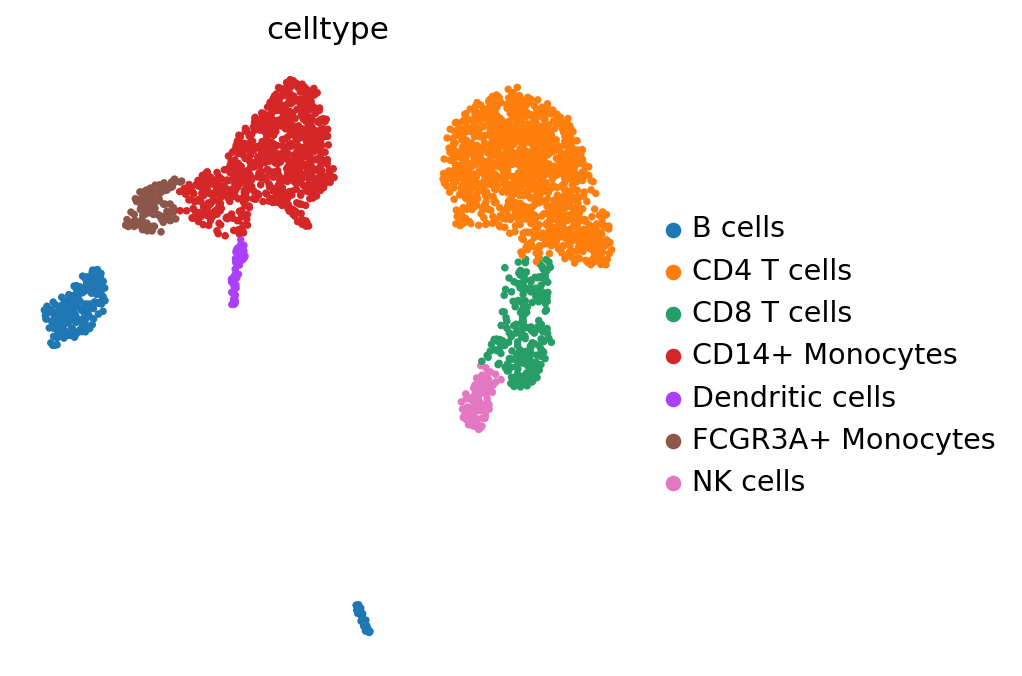

In [17]:
sc.pl.umap(adata, color = 'celltype')

In [18]:
adata.write(os.path.join(work_dir, 'scRNA/adata.h5ad'), compression='gzip')

Preprocessing ATACseq, as per SCENIC+:

In [1]:
import os
work_dir = 'data/pbmc'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/users/cbaker20/scratch'

In [2]:
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}


In [3]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [4]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [23]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 1,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

2023-10-02 21:31:35,489 cisTopic     INFO     Reading fragments from data/pbmc/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
2023-10-02 21:32:19,561 cisTopic     INFO     Creating pseudobulk for Bcells
2023-10-02 21:33:07,399 cisTopic     INFO     Bcells done!
2023-10-02 21:33:07,402 cisTopic     INFO     Creating pseudobulk for CD14_Monocytes
2023-10-02 21:36:01,002 cisTopic     INFO     CD14_Monocytes done!
2023-10-02 21:36:01,018 cisTopic     INFO     Creating pseudobulk for CD4Tcells
2023-10-02 21:39:44,322 cisTopic     INFO     CD4Tcells done!
2023-10-02 21:39:44,324 cisTopic     INFO     Creating pseudobulk for CD8Tcells
2023-10-02 21:40:19,620 cisTopic     INFO     CD8Tcells done!
2023-10-02 21:40:19,723 cisTopic     INFO     Creating pseudobulk for Dendriticcells
2023-10-02 21:40:32,755 cisTopic     INFO     Dendriticcells done!
2023-10-02 21:40:32,756 cisTopic     INFO     Creating pseudobulk for FCGR3A_Monocytes
2023-10-02 21:40:51,890 cisTopic     INFO     FCGR3A_Monocyte

In [24]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [25]:
import os

In [26]:
import pickle
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='/users/cbaker20/.conda/envs/scootr/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=5,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2023-10-02 21:41:09,300 root         INFO     Unable to poll TPU GCE metadata: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/attributes/accelerator-type (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7f8aa789ba30>: Failed to resolve 'metadata.google.internal' ([Errno -2] Name or service not known)"))


2023-10-02 21:41:10,543	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(macs_call_peak_ray pid=82284) 2023-10-02 21:41:14,167 cisTopic     INFO     Calling peaks for Dendriticcells with /users/cbaker20/.conda/envs/scootr/bin/macs2 callpeak --treatment data/pbmc/scATAC/consensus_peak_calling/pseudobulk_bed_files/Dendriticcells.bed.gz --name Dendriticcells  --outdir data/pbmc/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=82282) 2023-10-02 21:41:14,167 cisTopic     INFO     Calling peaks for CD4Tcells with /users/cbaker20/.conda/envs/scootr/bin/macs2 callpeak --treatment data/pbmc/scATAC/consensus_peak_calling/pseudobulk_bed_files/CD4Tcells.bed.gz --name CD4Tcells  --outdir data/pbmc/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=82283) 2023-10-02 21:41:14,167 cisTopic     INFO     Calling peaks for Bcel

In [27]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [28]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2023-10-02 21:42:23,488 cisTopic     INFO     Extending and merging peaks per class
2023-10-02 21:42:55,787 cisTopic     INFO     Normalizing peak scores
2023-10-02 21:42:55,969 cisTopic     INFO     Merging peaks
2023-10-02 21:43:39,421 cisTopic     INFO     Done!


In [29]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

In [30]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

/tmp/ipykernel_80672/2503884162.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


2023-10-02 21:43:57,417 cisTopic     INFO     Reading 10x_pbmc
2023-10-02 21:44:34,763 cisTopic     INFO     Computing barcode rank plot for 10x_pbmc
2023-10-02 21:44:34,764 cisTopic     INFO     Counting fragments
2023-10-02 21:44:37,060 cisTopic     INFO     Marking barcodes with more than 100
2023-10-02 21:44:37,086 cisTopic     INFO     Returning plot data
2023-10-02 21:44:37,087 cisTopic     INFO     Returning valid barcodes
2023-10-02 21:44:39,488 cisTopic     INFO     Computing duplicate rate plot for 10x_pbmc
2023-10-02 21:44:42,447 cisTopic     INFO     Return plot data
2023-10-02 21:44:42,714 cisTopic     INFO     Computing insert size distribution for 10x_pbmc
2023-10-02 21:44:42,714 cisTopic     INFO     Counting fragments
2023-10-02 21:44:43,585 cisTopic     INFO     Returning plot data
2023-10-02 21:45:04,853 cisTopic     INFO     Computing TSS profile for 10x_pbmc
2023-10-02 21:45:06,863 cisTopic     INFO     Formatting annnotation
2023-10-02 21:45:06,924 cisTopic     IN

In [8]:
import pickle

file = open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb')
metadata_bc = pickle.load(file)
file = open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'rb')
profile_data_dict = pickle.load(file)

/oscar/home/cbaker20/pycisTopic/pycisTopic/qc.py:1880: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/users/cbaker20/.conda/envs/scootr/lib/python3.9/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/oscar/home/cbaker20/pycisTopic/pycisTopic/qc.py:1895: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexib

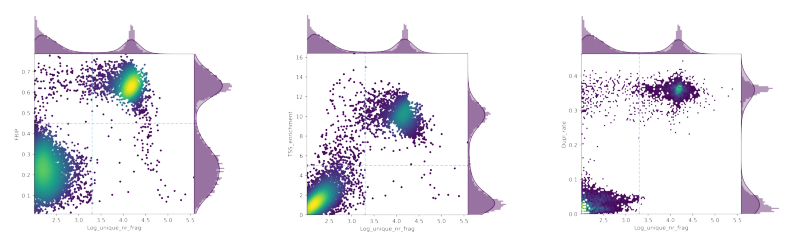

In [11]:
                         #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
bc_passing_filters = {'10x_pbmc':[]}
bc_passing_filters['10x_pbmc'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_pbmc'])} barcodes passed QC stats")

2521 barcodes passed QC stats


In [7]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [9]:
import pickle
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [10]:
print(f"{len(list(set(bc_passing_filters['10x_pbmc']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

2407 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


In [19]:
from pycisTopic.cistopic_class import *
key = '10x_pbmc'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

2023-10-02 22:11:46,802 cisTopic     INFO     Reading data for 10x_pbmc
2023-10-02 22:12:24,289 cisTopic     INFO     metrics provided!
2023-10-02 22:12:27,206 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-10-02 22:12:29,444 cisTopic     INFO     Counting fragments in regions
2023-10-02 22:12:48,423 cisTopic     INFO     Creating fragment matrix
2023-10-02 22:13:05,547 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-10-02 22:13:08,084 cisTopic     INFO     Removing blacklisted regions
2023-10-02 22:13:09,290 cisTopic     INFO     Creating CistopicObject
2023-10-02 22:13:10,030 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project 10x_pbmc with n_cells × n_regions = 2407 × 192527


In [20]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [4]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[50],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

2023-10-11 10:36:11,763	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_cgs_model pid=228073) 2023-10-11 10:36:15,299 cisTopic     INFO     Running model with 50 topics
(run_cgs_model pid=228073) 2023-10-11 12:10:13,529 cisTopic     INFO     Model with 50 topics done!


In [5]:
pickle.dump(models, open(os.path.join(work_dir, 'scATAC/models/50_peaks.pkl'), 'wb'))

In [13]:
pickle.dump(models, open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'data/pbmc/scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'

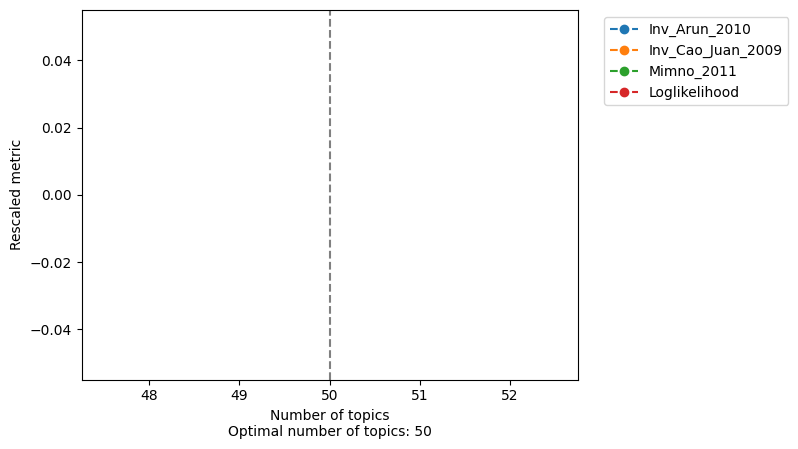

In [7]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/50_peaks.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=50,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [8]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [3]:
import os
work_dir = 'data/pbmc'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/users/cbaker20/scratch'

In [4]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))

In [5]:
y = cistopic_obj.selected_model.cell_topic.transpose().to_numpy()

In [ ]:
%%capture
import src.scootr as scoot
#import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

X_raw = np.loadtxt("./data/CITEseq/citeseq_adt_normalized_1000cells.csv", delimiter=",")
y_raw = np.loadtxt("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv", delimiter=",")